In [2]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [14]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150
plt.style.use("paper")

In [4]:
hpr = pd.read_csv("02_data/mace_hyperparams.csv", index_col=0)
lcv = pd.read_csv("02_data/mace_learning.csv", index_col=0)
lls = pd.read_csv("02_data/mace_losslands.csv", index_col=0)
sdf = pd.read_csv("02_data/mace_entropy.csv", index_col=0)
exp = pd.read_csv("02_data/mace_explosion.csv", index_col=0)
ext = pd.read_csv("02_data/mace_extrapolation_errors.csv", index_col=0)

In [24]:
LABELS = {
    "no_rescaling": "v=2, L=3, no rescaling",
    "no_bessel": "v=2, L=3, all opt",
    "only_rescaling": "v=2, L=3, rescaling",
    "rescaling+bessel": "v=2, L=3, Bessel",
    "v2-base": "v=2, L=3, baseline",
    "v2-amsgrad": "v=2, L=3, AMSGrad",
    "v2-ema": "v=2, L=3, EMA",
    "v2-swa": "v=2, L=3, SWA",
    "v3_l3": "v=3, L=3",
    "v2_l3": "v=2, L=3",
    "v1_l3": "v=1, L=3",
    "v2_l2": "v=2, L=2",
    "v2_l1": "v=2, L=1",
    "v2_l0": "v=2, L=0",
    "v1_l0": "v=1, L=0",
}
FIGS_DIR = "04_si"

In [6]:
MODELS = {
    "BIG": ["no_rescaling", "no_bessel", "only_rescaling", "rescaling+bessel"],
    "OPT":  ["v2-base", "v2-swa", "v2-ema", "v2-amsgrad"],
    "V1": ["v1_l0", "v1_l3"],
    "V2": ["v2_l0", "v2_l1", "v2_l2", "v2_l3"] ,
    "VL3": ["v1_l3", "v2_l3", "v3_l3"],
}

MODELS_ORDER = MODELS["BIG"] + MODELS["OPT"] + MODELS["V1"] + MODELS["V2"] + MODELS["VL3"]
MODELS_L3 = MODELS["BIG"] + MODELS["OPT"] + MODELS["VL3"]

In [7]:
CMAPS = {
    "BIG": cm.Reds_r,
    "OPT": cm.Blues_r,
    "V1": cm.Greys_r,
    "V2": cm.Greens_r,
    "VL3": cm.Purples_r,
}

In [8]:
labels = pd.DataFrame(LABELS.values(), index=LABELS.keys(), columns=["label"])

In [9]:
_colors = {}
for mset, cases in MODELS.items():
    norm = plt.Normalize(0, len(cases))
    for i, name in enumerate(cases):
        _colors[name] = CMAPS[mset](norm(i))
    
labels["color"] = pd.Series(_colors)

## Sensitivity analysis of the LLs

In [10]:
def get_entropy(x, T=1e-2, k=1.0):
    y = x
    beta = 1 / (k * T)
    Q = np.sum(np.exp(-beta * y))
    return k * np.log(Q)

In [11]:
_sdf = []

T_F = 4e-2
T_E = 4e-3
ALPHA = 0.2
X_THRESHOLD = 0.025

for T in np.logspace(-3, -1, 1000):
    for model, _df in lls.groupby("model"):    
        Sf = get_entropy(_df["f"].values, T=T)
        Se = get_entropy(_df["e"].values, T=T)

        _subdf = _df.loc[np.abs(_df.x) < X_THRESHOLD]

        _sdf.append({
            "model": model,
            "Se": Se,
            "Sf": Sf,
            "T": T,
        })
    
sdf = pd.DataFrame(_sdf)
perfect_s = get_entropy(np.zeros(81))

webf NOT subset; don't know how to subset; dropped


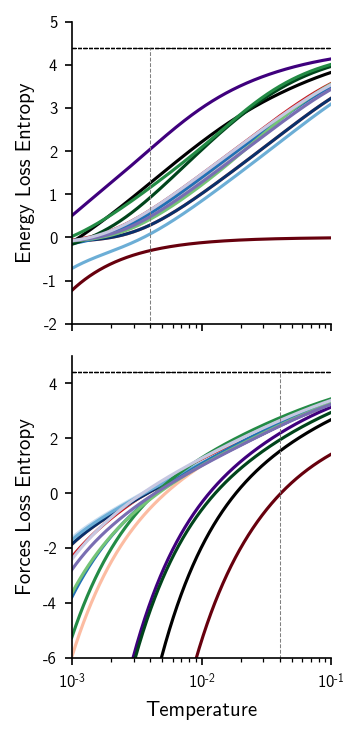

In [25]:
fig, ax_fig = plt.subplots(2, 1, figsize=(2.5, 5), sharex=True)

for ax, qty in zip(ax_fig, ["Se", "Sf"]):
    for model, _df in sdf.groupby("model"):
        color = labels.loc[model]["color"]
        ax.plot(_df["T"], _df[qty], color=color, label=model)
        
        ax.plot(
            [1e-3, 1e-1],
            [perfect_s, perfect_s],
            "k--",
            linewidth=0.5,
        )

    ax.set_xscale("log")
    ax.set_xlim(1e-3, 1e-1)

ax_fig[0].set_ylim(-2, 5)
ax_fig[1].set_ylim(-6, 5)

ax_fig[0].set_ylabel("Energy Loss Entropy")
ax_fig[1].set_ylabel("Forces Loss Entropy")
ax_fig[1].set_xlabel("Temperature")

ax_fig[0].plot(
    [4e-3, 4e-3],
    [-5, perfect_s],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax_fig[1].plot(
    [4e-2, 4e-2],
    [-10, perfect_s],
    "--",
    color="#808080",
    linewidth=0.5,
)

# ax_fig[1].legend(frameon=False, fontsize="x-small", bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(f"{FIGS_DIR}/mace_temperature.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Verifying changes in rank with respect to temperature

In [26]:
_corr = []

T_F = 4e-2
T_E = 4e-3

for T, _df in sdf.groupby("T"):
    _df = _df.set_index("model")
    
    qty = "Se"
    BASE_T = T_E
    base_df = sdf.loc[np.abs(sdf["T"] - BASE_T) == np.abs(sdf["T"] - BASE_T).min()].set_index("model")
    base_df = base_df.sort_values(qty)
    _df = _df.loc[base_df.index]
    e_corr, _ = stats.spearmanr(base_df[qty], _df[qty])

    qty = "Sf"
    BASE_T = T_F
    base_df = sdf.loc[np.abs(sdf["T"] - BASE_T) == np.abs(sdf["T"] - BASE_T).min()].set_index("model")
    base_df = base_df.sort_values(qty)
    _df = _df.loc[base_df.index]
    f_corr, _ = stats.spearmanr(base_df[qty], _df[qty])

    _corr.append({
        "T": T,
        "e_corr": e_corr,
        "f_corr": f_corr,
    })

corr = pd.DataFrame(_corr)

webf NOT subset; don't know how to subset; dropped


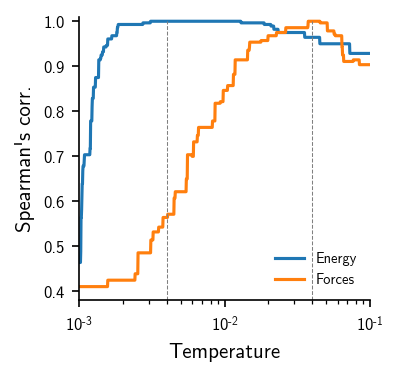

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

ax.plot(corr["T"], corr["e_corr"], label="Energy")
ax.plot(corr["T"], corr["f_corr"], label="Forces")

ax.set_xscale("log")
ax.set_xlim(1e-3, 1e-1)

ax.set_xlabel("Temperature")
ax.set_ylabel("Spearman's corr.")

ymin = ax.get_ylim()[0]
ax.plot(
    [T_E, T_E],
    [ymin, 1],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax.plot(
    [T_F, T_F],
    [ymin, 1],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax.set_ylim(ymin, 1.01)

ax.legend(frameon=False, fontsize="x-small", loc="lower right")
fig.savefig(f"{FIGS_DIR}/mace_correlation.pdf", bbox_inches='tight', transparent=True)
plt.show()